In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import seaborn as sns
from pypalettes import load_cmap

import functions.eddy_feedback as ef

# Import data

### All 15 PAMIP models (including fabricated AWI)

In [2]:
# Import EFP values (mixed-freq)
directory_path = '/home/links/ct715/eddy_feedback/chapter1/efp_random/data/non-regridded_efp_AWI-fabricated.csv'
df = pd.read_csv(directory_path, index_col=0)

# correct resolution values
correct_res = {
    'CESM2': 1.25,
    'CanESM5': 2.8,
    'CNRM-CM6-1': 1.0,
    'E3SMv1': 1.0,
    'EC-EARTH3': 1.0,
    'AWI-CM-1-1-MR': 0.94,
    'FGOALS-f3-L': 1.0,
    'HadGEM3-GC31-MM': 0.55,
    'HadGEM3-GC31-LL': 1.25,
    'IPSL-CM6A-LR': 1.26,
    'MIROC6': 1.4,
    'NorESM2-LM': 1.9,
    'OpenIFS-159': 1.125,
    'OpenIFS-511': 0.352,
    'OpenIFS-1279': 0.14,
    'CESM1-WACCM-SC': 1.9
}

# Convert to DataFrame
res_df = pd.DataFrame([
    {"model": model, "lat_res": res}
    for model, res in correct_res.items()
])

# Merge on 'Model'
merged_df = df.merge(res_df, on="model", how="left")
df = merged_df.sort_values(by=['model']).reset_index(drop=True)
# df

### Daily EFP (8 models)

In [3]:
directory_path = '/home/links/ct715/eddy_feedback/chapter1/efp_random/data/daily_efp_8models.csv'
df_daily = pd.read_csv(directory_path, index_col=0)

merged_df = df_daily.merge(res_df, on="model", how="left")
df_daily = merged_df.sort_values(by=['model']).reset_index(drop=True)
# df_daily

### Subset mixed-freq to match daily-efp

In [4]:
df2 = df[df['model'].isin(df_daily['model'])].reset_index(drop=True)
# df2

### Drop some models, if required

:warning: Watch out for incorrect resolution with OpenIFS-511!!

In [5]:
df = df.drop(index=14) # drop OpenIFS-511


## DROP CanESM5 ## 
# df = df.drop(index=4) # drop CanESM5
# df2 = df2.drop(index=2) # drop CanESM5
# df_daily = df_daily.drop(index=2) # drop CanESM5

# ALL 15 mixed-freq EFP values (including fabricated AWI)

In [6]:
import seaborn as sns
from pypalettes import load_cmap

# Example: 15 models
models = df["model"].unique().tolist()

# Colours from a continuous cmap
cmap = load_cmap("Signac")
colors = [cmap(i / (len(models) - 1)) for i in range(len(models))]
palette = dict(zip(models, colors))

# Markers (choose a set of distinct markers seaborn/matplotlib supports)
all_markers = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "d", "p", "H", 'h', "*"]
markers = dict(zip(models, all_markers[:len(models)]))

# ✅ Subset for only the models you need later:
subset = models[:8]  # or any list of model names
subset_palette = {m: palette[m] for m in subset}
subset_markers = {m: markers[m] for m in subset}

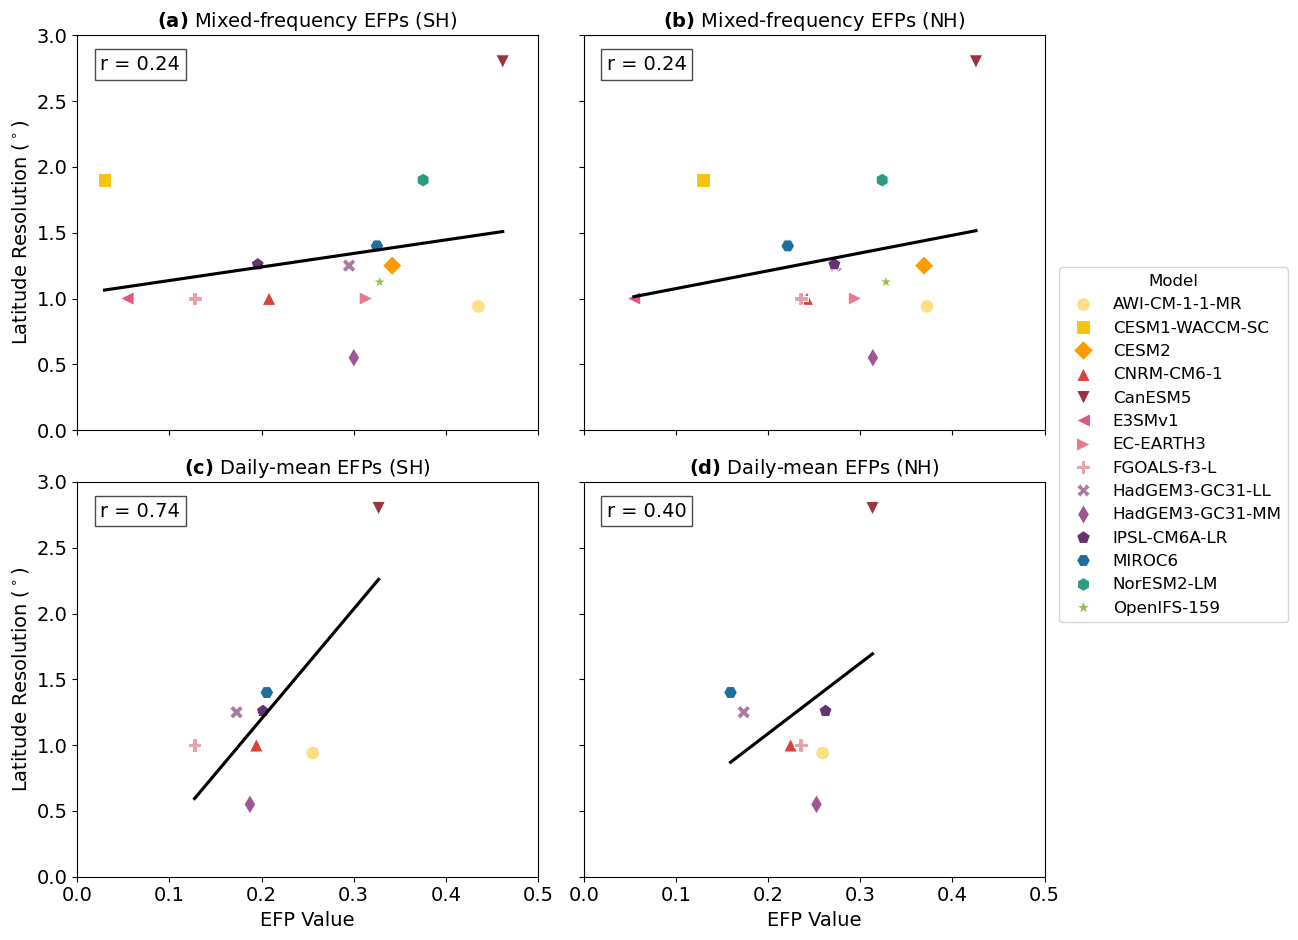

In [7]:
# Create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True, sharex=True)

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=14, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))
    
# TOP ROW
#------------------------------------------------------------

# (a) Mixed-frequency (SH)
sns.scatterplot(
    x=df["efp_sh"], 
    y=df["lat_res"], 
    hue=df["model"], 
    style=df["model"], 
    ax=axes[0,0],  # now SH in col=0
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df["efp_sh"], 
    y=df["lat_res"], 
    scatter=False, 
    ax=axes[0,0], 
    color="black", 
    ci=None
)
axes[0,0].set_title("$\\bf{(a)}$ Mixed-frequency EFPs (SH)", fontsize=14)
axes[0,0].set_xlabel("EFP Value", fontsize=14)
axes[0,0].set_ylabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[0,0].set_xlim(0,0.5)
axes[0,0].set_ylim(0,3)
axes[0,0].tick_params(labelsize=14)
axes[0,0].get_legend().remove()
add_correlation(axes[0,0], df["efp_sh"], df["lat_res"])

# (b) Northern Hemisphere
sns.scatterplot(
    x=df["efp_nh"], 
    y=df["lat_res"], 
    hue=df["model"], 
    style=df["model"], 
    ax=axes[0,1],  # now NH in col=1
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df["efp_nh"], 
    y=df["lat_res"], 
    scatter=False, 
    ax=axes[0,1], 
    color="black", 
    ci=None
)
axes[0,1].set_title("$\\bf{(b)}$ Mixed-frequency EFPs (NH)", fontsize=14)
axes[0,1].set_xlabel("EFP Value", fontsize=14)
axes[0,1].set_xlim(0,0.5)
axes[0,1].set_ylim(0,3)
axes[0,1].tick_params(labelsize=14)
axes[0,1].legend().remove()
add_correlation(axes[0,1], df["efp_nh"], df["lat_res"])

# BOTTOM ROW
#------------------------------------------------------------

# (c) Daily-mean (SH, without CanESM5)
sns.scatterplot(
    x=df_daily["efp_sh"], 
    y=df_daily["lat_res"], 
    hue=df_daily["model"], 
    style=df_daily["model"], 
    ax=axes[1,0],  # SH now col=0
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df_daily["efp_sh"], 
    y=df_daily["lat_res"], 
    scatter=False, 
    ax=axes[1,0], 
    color="black", 
    ci=None
)
axes[1,0].set_title("$\\bf{(c)}$ Daily-mean EFPs (SH)", fontsize=14)
axes[1,0].set_xlabel("EFP Value", fontsize=14)
axes[1,0].set_ylabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[1,0].set_xlim(0,0.5)
axes[1,0].set_ylim(0,3)
axes[1,0].tick_params(labelsize=14)
axes[1,0].get_legend().remove()
add_correlation(axes[1,0], df_daily["efp_sh"], df_daily["lat_res"])

# (d) Daily-mean (NH, without CanESM5)
sns.scatterplot(
    x=df_daily["efp_nh"], 
    y=df_daily["lat_res"], 
    hue=df_daily["model"], 
    style=df_daily["model"], 
    ax=axes[1,1],  # NH now col=1
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df_daily["efp_nh"], 
    y=df_daily["lat_res"], 
    scatter=False, 
    ax=axes[1,1], 
    color="black", 
    ci=None
)
axes[1,1].set_title("$\\bf{(d)}$ Daily-mean EFPs (NH)", fontsize=14)
axes[1,1].set_xlabel("EFP Value", fontsize=14)
axes[1,1].set_xlim(0,0.5)
axes[1,1].set_ylim(0,3)
axes[1,1].tick_params(labelsize=14)
axes[1,1].get_legend().remove()
add_correlation(axes[1,1], df_daily["efp_nh"], df_daily["lat_res"])

# Get handles and labels from one plot
handles, labels = axes[0,1].get_legend_handles_labels()

# Add a figure-level legend, centered vertically on the right
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.88, 0.5),
           fontsize=12, title='Model', title_fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# MATCHED to daily EFP (8 models)

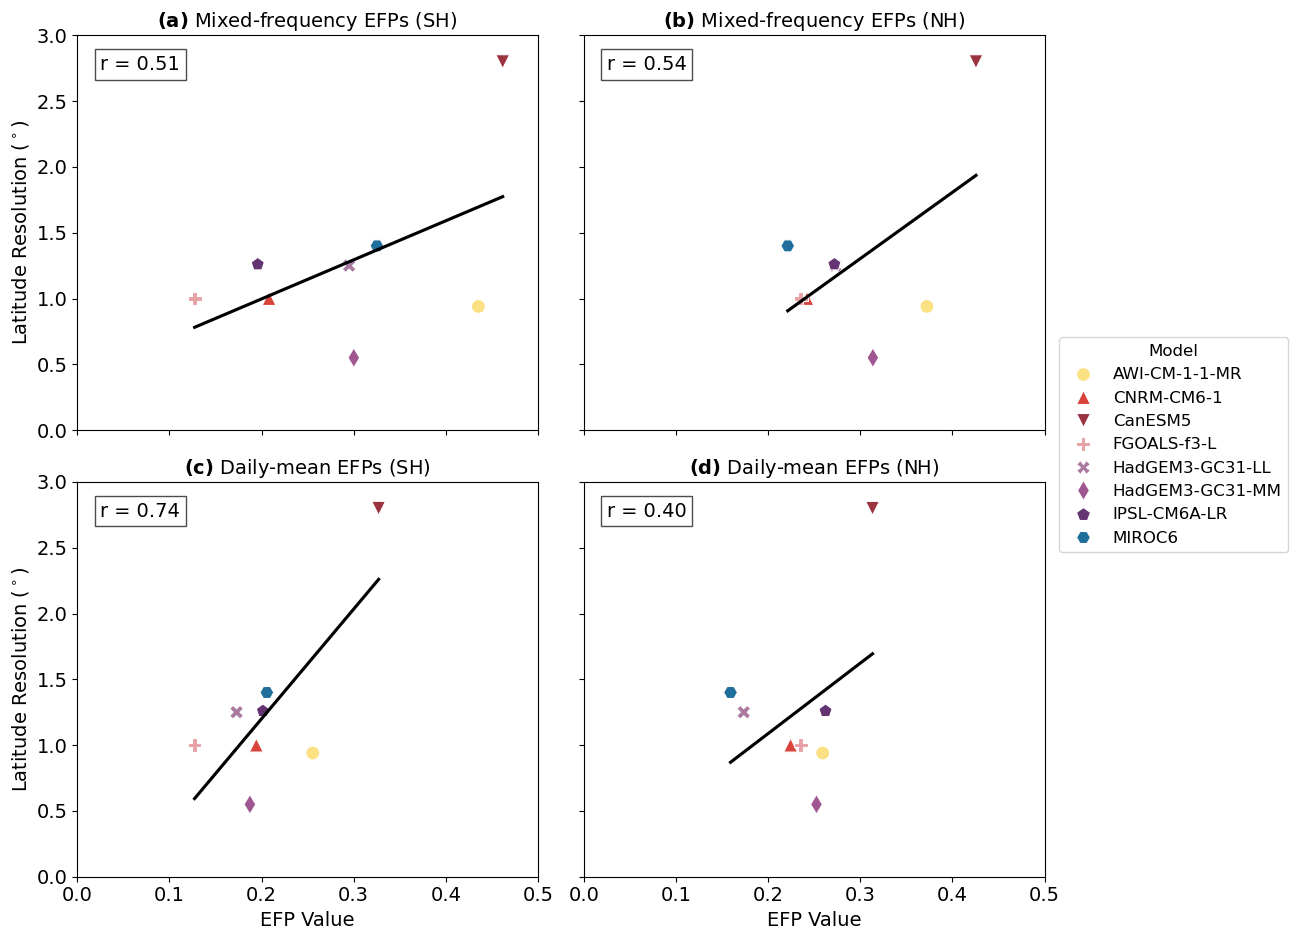

In [8]:
# Create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True, sharex=True)

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=14, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

# TOP ROW
#------------------------------------------------------------

# (a) Mixed-frequency (SH)
sns.scatterplot(
    x=df2["efp_sh"], 
    y=df2["lat_res"], 
    hue=df2["model"], 
    style=df2["model"], 
    ax=axes[0,0],  # SH in col=0
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df2["efp_sh"], 
    y=df2["lat_res"], 
    scatter=False, 
    ax=axes[0,0], 
    color="black", 
    ci=None
)
axes[0,0].set_title("$\\bf{(a)}$ Mixed-frequency EFPs (SH)", fontsize=14)
axes[0,0].set_xlabel("EFP Value", fontsize=14)
axes[0,0].set_ylabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[0,0].set_xlim(0,0.5)
axes[0,0].set_ylim(0,3)
axes[0,0].tick_params(labelsize=14)
axes[0,0].get_legend().remove()
add_correlation(axes[0,0], df2["efp_sh"], df2["lat_res"])

# (b) Mixed-frequency (NH)
sns.scatterplot(
    x=df2["efp_nh"], 
    y=df2["lat_res"], 
    hue=df2["model"], 
    style=df2["model"], 
    ax=axes[0,1],  # NH in col=1
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df2["efp_nh"], 
    y=df2["lat_res"], 
    scatter=False, 
    ax=axes[0,1], 
    color="black", 
    ci=None
)
axes[0,1].set_title("$\\bf{(b)}$ Mixed-frequency EFPs (NH)", fontsize=14)
axes[0,1].set_xlabel("EFP Value", fontsize=14)
axes[0,1].set_xlim(0,0.5)
axes[0,1].set_ylim(0,3)
axes[0,1].tick_params(labelsize=14)
axes[0,1].legend().remove()
add_correlation(axes[0,1], df2["efp_nh"], df2["lat_res"])

# BOTTOM ROW
#------------------------------------------------------------

# (c) Daily-mean (SH, without CanESM5)
sns.scatterplot(
    x=df_daily["efp_sh"], 
    y=df_daily["lat_res"], 
    hue=df_daily["model"], 
    style=df_daily["model"], 
    ax=axes[1,0],  # SH in col=0
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df_daily["efp_sh"], 
    y=df_daily["lat_res"], 
    scatter=False, 
    ax=axes[1,0], 
    color="black", 
    ci=None
)
axes[1,0].set_title("$\\bf{(c)}$ Daily-mean EFPs (SH)", fontsize=14)
axes[1,0].set_xlabel("EFP Value", fontsize=14)
axes[1,0].set_ylabel("Latitude Resolution ($^\\circ$)", fontsize=14)
axes[1,0].set_xlim(0,0.5)
axes[1,0].set_ylim(0,3)
axes[1,0].tick_params(labelsize=14)
axes[1,0].get_legend().remove()
add_correlation(axes[1,0], df_daily["efp_sh"], df_daily["lat_res"])

# (d) Daily-mean (NH, without CanESM5)
sns.scatterplot(
    x=df_daily["efp_nh"], 
    y=df_daily["lat_res"], 
    hue=df_daily["model"], 
    style=df_daily["model"], 
    ax=axes[1,1],  # NH in col=1
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df_daily["efp_nh"], 
    y=df_daily["lat_res"], 
    scatter=False, 
    ax=axes[1,1], 
    color="black", 
    ci=None
)
axes[1,1].set_title("$\\bf{(d)}$ Daily-mean EFPs (NH)", fontsize=14)
axes[1,1].set_xlabel("EFP Value", fontsize=14)
axes[1,1].set_xlim(0,0.5)
axes[1,1].set_ylim(0,3)
axes[1,1].tick_params(labelsize=14)
axes[1,1].get_legend().remove()
add_correlation(axes[1,1], df_daily["efp_nh"], df_daily["lat_res"])

# Get handles and labels from one plot
handles, labels = axes[0,1].get_legend_handles_labels()

# Add a figure-level legend, centered vertically on the right
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.88, 0.5),
           fontsize=12, title='Model', title_fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for legend
plt.show()

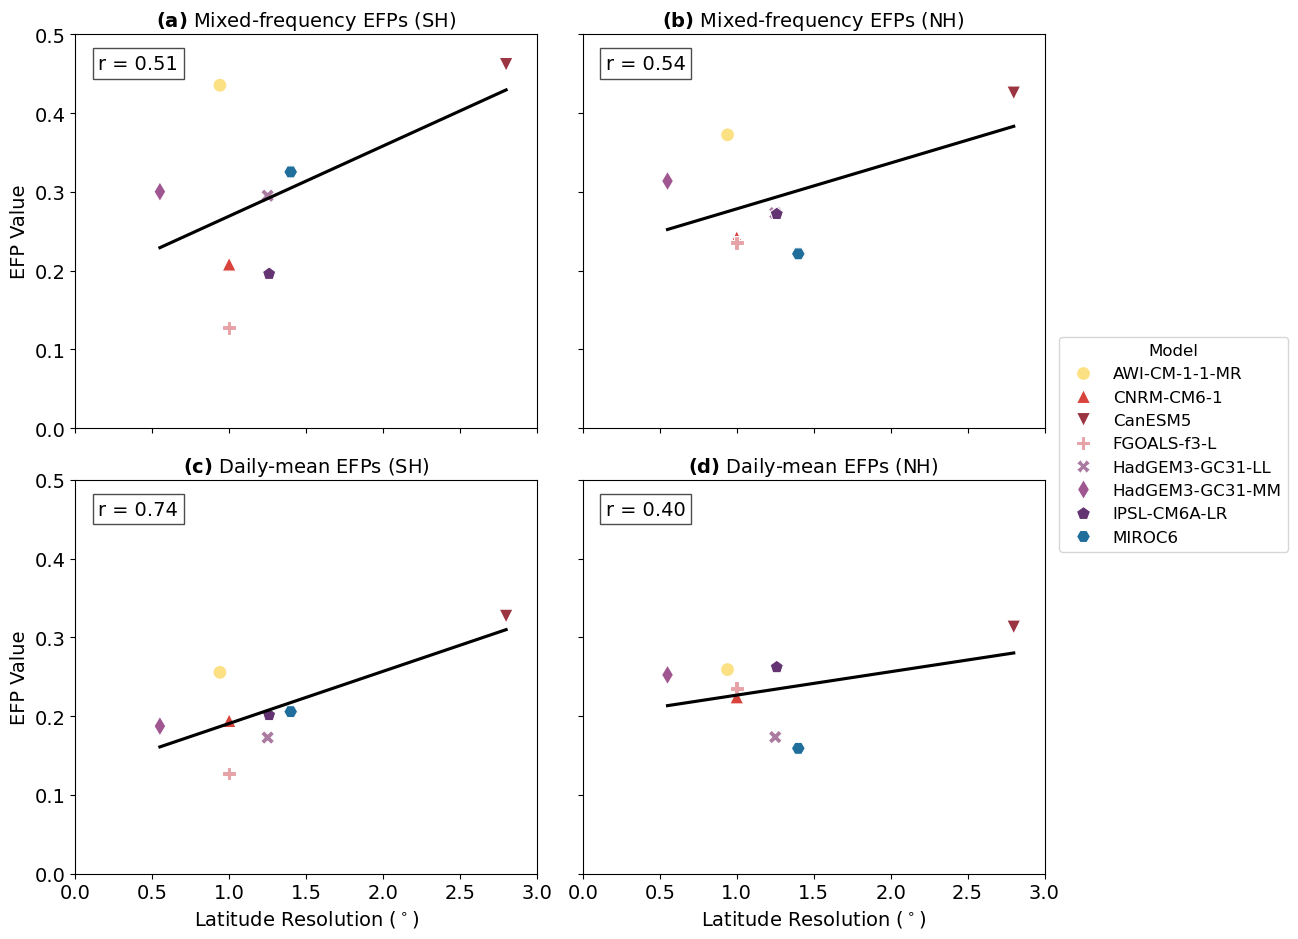

In [9]:
# Create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True, sharex=True)

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=14, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

# TOP ROW
#------------------------------------------------------------

# (a) Mixed-frequency (SH)
sns.scatterplot(
    x=df2["lat_res"],  # Switched
    y=df2["efp_sh"],   # Switched
    hue=df2["model"], 
    style=df2["model"], 
    ax=axes[0,0],  # SH in col=0
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df2["lat_res"],  # Switched
    y=df2["efp_sh"],   # Switched
    scatter=False, 
    ax=axes[0,0], 
    color="black", 
    ci=None
)
axes[0,0].set_title("$\\bf{(a)}$ Mixed-frequency EFPs (SH)", fontsize=14)
axes[0,0].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)  # Switched
axes[0,0].set_ylabel("EFP Value", fontsize=14)  # Switched
axes[0,0].set_xlim(0,3)  # Switched
axes[0,0].set_ylim(0,0.5)  # Switched
axes[0,0].tick_params(labelsize=14)
axes[0,0].get_legend().remove()
add_correlation(axes[0,0], df2["lat_res"], df2["efp_sh"])  # Switched

# (b) Mixed-frequency (NH)
sns.scatterplot(
    x=df2["lat_res"],  # Switched
    y=df2["efp_nh"],   # Switched
    hue=df2["model"], 
    style=df2["model"], 
    ax=axes[0,1],  # NH in col=1
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df2["lat_res"],  # Switched
    y=df2["efp_nh"],   # Switched
    scatter=False, 
    ax=axes[0,1], 
    color="black", 
    ci=None
)
axes[0,1].set_title("$\\bf{(b)}$ Mixed-frequency EFPs (NH)", fontsize=14)
axes[0,1].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)  # Switched
axes[0,1].set_ylabel("EFP Value", fontsize=14)  # Switched
axes[0,1].set_xlim(0,3)  # Switched
axes[0,1].set_ylim(0,0.5)  # Switched
axes[0,1].tick_params(labelsize=14)
axes[0,1].legend().remove()
add_correlation(axes[0,1], df2["lat_res"], df2["efp_nh"])  # Switched

# BOTTOM ROW
#------------------------------------------------------------

# (c) Daily-mean (SH, without CanESM5)
sns.scatterplot(
    x=df_daily["lat_res"],  # Switched
    y=df_daily["efp_sh"],   # Switched
    hue=df_daily["model"], 
    style=df_daily["model"], 
    ax=axes[1,0],  # SH in col=0
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df_daily["lat_res"],  # Switched
    y=df_daily["efp_sh"],   # Switched
    scatter=False, 
    ax=axes[1,0], 
    color="black", 
    ci=None
)
axes[1,0].set_title("$\\bf{(c)}$ Daily-mean EFPs (SH)", fontsize=14)
axes[1,0].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)  # Switched
axes[1,0].set_ylabel("EFP Value", fontsize=14)  # Switched
axes[1,0].set_xlim(0,3)  # Switched
axes[1,0].set_ylim(0,0.5)  # Switched
axes[1,0].tick_params(labelsize=14)
axes[1,0].get_legend().remove()
add_correlation(axes[1,0], df_daily["lat_res"], df_daily["efp_sh"])  # Switched

# (d) Daily-mean (NH, without CanESM5)
sns.scatterplot(
    x=df_daily["lat_res"],  # Switched
    y=df_daily["efp_nh"],   # Switched
    hue=df_daily["model"], 
    style=df_daily["model"], 
    ax=axes[1,1],  # NH in col=1
    s=100,
    palette=palette,
    markers=markers
)
sns.regplot(
    x=df_daily["lat_res"],  # Switched
    y=df_daily["efp_nh"],   # Switched
    scatter=False, 
    ax=axes[1,1], 
    color="black", 
    ci=None
)
axes[1,1].set_title("$\\bf{(d)}$ Daily-mean EFPs (NH)", fontsize=14)
axes[1,1].set_xlabel("Latitude Resolution ($^\\circ$)", fontsize=14)  # Switched
axes[1,1].set_ylabel("EFP Value", fontsize=14)  # Switched
axes[1,1].set_xlim(0,3)  # Switched
axes[1,1].set_ylim(0,0.5)  # Switched
axes[1,1].tick_params(labelsize=14)
axes[1,1].get_legend().remove()
add_correlation(axes[1,1], df_daily["lat_res"], df_daily["efp_nh"])  # Switched

# Get handles and labels from one plot
handles, labels = axes[0,1].get_legend_handles_labels()

# Add a figure-level legend, centered vertically on the right
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.88, 0.5),
           fontsize=12, title='Model', title_fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for legend
plt.show()